In [1]:
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [2]:
url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)

X = df.loc[:, df.columns != 'heart_attack']
y = df['heart_attack'] 

## 50/50 instead of 70/30 because of time
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size = .5, random_state=1, stratify=y) 

print(f"Total samples: {df.shape[0]}")
print(y.value_counts(normalize=True)) # to see if the heart-attack class is balanced

Total samples: 127030
heart_attack
0    0.50011
1    0.49989
Name: proportion, dtype: float64


In [3]:
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
    return wrapper

In [ ]:
## code prof
@compute_executions_time
def execute_voting_scheme_different_estimators_grid_search_and_cv(cv = b): 
    naive_bayes = GaussianNB()
    k_neighbors = KNeighborsClassifier()
    params_space = {
        "n_neighbors": list(range(1, 30, 2)),
        "weights": ["distance", "uniform"]
    }

    clf = GridSearchCV(
        k_neighbors, 
        param_grid = params_space,
        cv = cv,
        n_jobs = -1
    )
    ##clf.fit(X, y)
    clf.fit(X_train, y_train)
    best_parameters_for_knn = clf.best_params_
    print(f"Best Params for Knn: {clf.best_params_} - Accuracy: {clf.best_score_}")

    clf2 = KNeighborsClassifier(
        n_neighbors = best_parameters_for_knn["n_neighbors"],
        weights = best_parameters_for_knn["weights"]
    )
    clf3 = DecisionTreeClassifier(criterion="entropy")

    for clf, label in zip([naive_bayes, clf2, clf3], ["Naive Bayes",f"Knn ({best_parameters_for_knn['n_neighbors']})", "Dec. Tree"]):
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy")
        print(f"Accuracy: {scores.mean():.3f} [{label}]")

    warnings.filterwarnings("ignore", category=DeprecationWarning)  # Just to avoid warnings

    voting_classifier = VotingClassifier(
        estimators=[
            ("nb", naive_bayes),
            ("knn3", clf2),
            ("dt", clf3)
        ],
        voting = "hard"
    )
    scores = cross_val_score(
        voting_classifier,
        X,
        y,
        cv = cv,
        scoring = "accuracy")
    print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))

execute_voting_scheme_different_estimators_grid_search_and_cv()

Best Params for Knn: {'n_neighbors': 29, 'weights': 'distance'} - Accuracy: 0.7945029366232923
Accuracy: 0.806 [Naive Bayes]
Accuracy: 0.795 [Knn (29)]
Accuracy: 0.810 [Dec. Tree]
Accuracy: 0.833 [Majority Voting]

194.47595024108887 seconds


In [ ]:
modelGaussianNB = GaussianNB().fit(X_train, y_train)
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance').fit(X_train, y_train)
##modelSVM = LinearSVC(C=10, max_iter=10000).fit(X_train, y_train)
##modelSVM = SVC(C=10).fit(X_train, y_train)
modelSVM = SVC(kernel="linear", C=10).fit(X_train, y_train);
modelDT = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

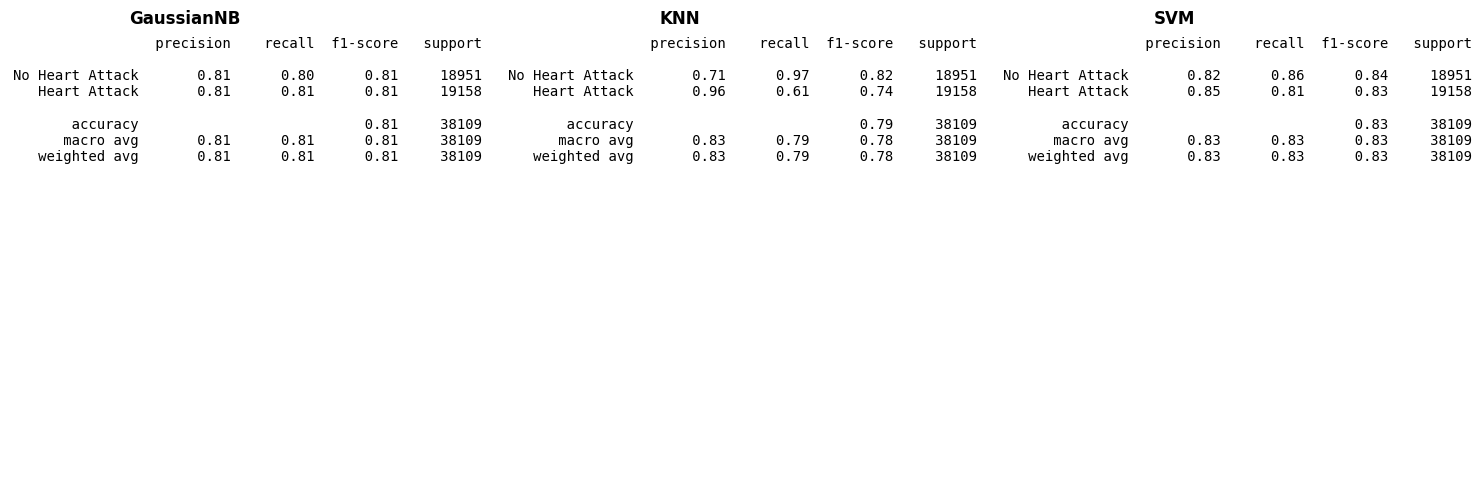

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

target_names = ['No Heart Attack', 'Heart Attack']

reportGNB = classification_report(y_test, modelGaussianNB.predict(X_test), target_names=target_names)
reportKNN = classification_report(y_test, modelKNN.predict(X_test), target_names=target_names)
reportSVM = classification_report(y_test, modelSVM.predict(X_test), target_names=target_names)

reports = [reportGNB, reportKNN, reportSVM]
titles = ['GaussianNB', 'KNN', 'SVM']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.99,  # Near top-left corner, top aligned
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    )
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [14]:
# Define base classifiers (untrained here, VotingClassifier will fit)
modelGaussianNB = GaussianNB()
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance')
modelDT = DecisionTreeClassifier(criterion='entropy')
modelSVM = SVC(C=10, max_iter=10000, probability = True) ##does not run
##modelSVM = LinearSVC(C=10, max_iter=10000) ##SVC roule pas, donc on ne peut pas faire soft voting

# Create VotingClassifier with these estimators
metaVoting = VotingClassifier(
    estimators=[
        ("GNB", modelGaussianNB),
        ("KNN", modelKNN),
        ("DT", modelDT),
        ("SVM", modelSVM)
    ],
    voting="hard"  # Soft voting requires classifiers to support predict_proba
)

# Define param grid to tune weights for each classifier
params = {
    "weights": [
        [1, 1, 1, 1],
        [2, 1, 1, 1],
        [1, 2, 1, 1],
        [1, 1, 2, 1],
        [1, 1, 1, 2],
        [2, 2, 1, 1],
        [1, 2, 2, 1],
        [1, 1, 2, 2],
        [2, 1, 1, 2],
        [2, 2, 2, 2]
    ]
}

# Create GridSearchCV on the VotingClassifier
modelVoting = GridSearchCV(
    metaVoting,
    param_grid=params,
    cv=10,
    n_jobs=-1
)

# Fit on your training data
modelVoting.fit(X_train, y_train)

print(f"Best Params for VotingClassifier = {modelVoting.best_params_} - Accuracy = {modelVoting.best_score_:.4f}")

Best Params for VotingClassifier = {'weights': [1, 1, 2, 2]} - Accuracy = 0.8428


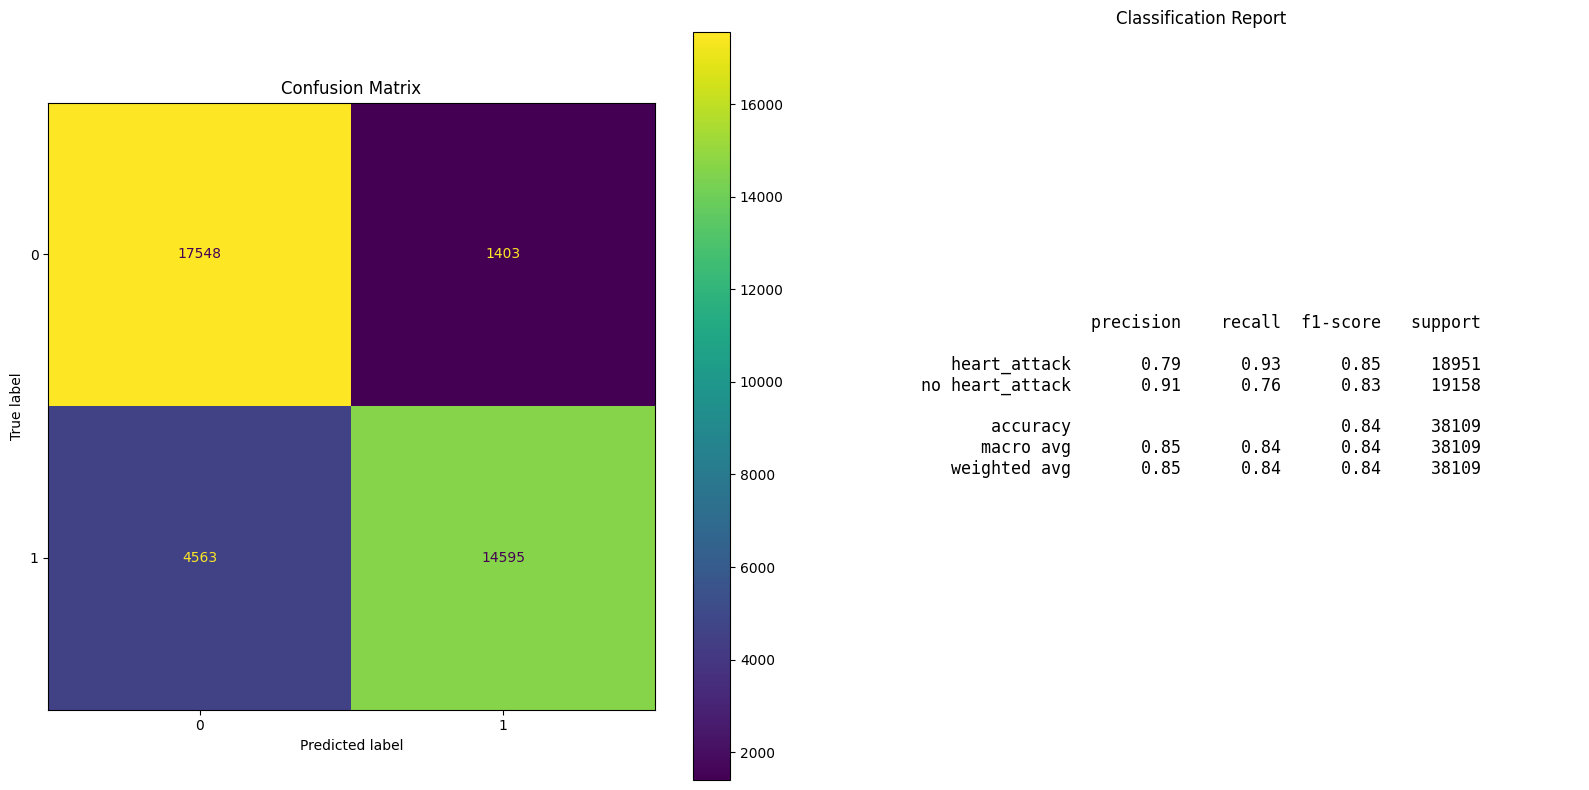

In [20]:
## je ne sais pas si c'est pertinent pour moi 
from sklearn.metrics import ConfusionMatrixDisplay


report = classification_report(
    y_test, 
    modelVoting.best_estimator_.predict(X_test), 
    target_names=['heart_attack', 'no heart_attack']
)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay.from_estimator(
    modelVoting.best_estimator_, 
    X_test, 
    y_test, 
    display_labels=['0', '1'], ## voir si je dois mettre heart_attack ou 1
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix')
axes[1].axis('off')
axes[1].text(0.5, 0.5, report, fontsize=12, ha='center', va='center', family='monospace')
axes[1].set_title('Classification Report')
plt.tight_layout()
plt.show()

## **Bagging**

In [29]:
lb=[]
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(), ##if we do not use a max depth, it will run 15 min juste for the nest = 50
            n_estimators = nest,
            random_state=1
        ), 
        X, 
        y, 
        cv = 5, 
        scoring="recall"
    )
    print(f"Recall: {scores.mean():.3f} [nº estimators: {nest}]")
    lb.append(scores.mean())

Recall: 0.810 [nº estimators: 1]
Recall: 0.738 [nº estimators: 2]
Recall: 0.815 [nº estimators: 5]
Recall: 0.794 [nº estimators: 10]
Recall: 0.802 [nº estimators: 20]
Recall: 0.805 [nº estimators: 50]
Recall: 0.808 [nº estimators: 100]
Recall: 0.808 [nº estimators: 200]


In [ ]:
lb2=[]
print()
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(),
            n_estimators = nest,
            max_features = 0.35,
            random_state=1
        ), 
        X, 
        y, 
        cv = 5, 
        scoring="recall"
    )
    print(f"Recall: {scores.mean():.3f} [nº estimators: {nest}]")
    lb2.append(scores.mean())


Accuracy: 0.623 [nº estimators: 1]
Accuracy: 0.592 [nº estimators: 2]
Accuracy: 0.666 [nº estimators: 5]
Accuracy: 0.714 [nº estimators: 10]


KeyboardInterrupt: 

In [ ]:
def baggingCV(model, name):
    for nest in [1,2,5,10,20,50,100]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = model,
                n_estimators = nest,
                random_state=1
            ), 
            X_train, 
            y_train, 
            cv = 5, 
            scoring = "recall"
        )
        print("Recall %s: %0.3f [%s]" % (name, scores.mean(), nest))
    
baggingCV(GaussianNB(), "GNB")
print()
baggingCV(KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance'), "KNN")
print()    

Recall GNB: 0.811 [1]
Recall GNB: 0.811 [2]
Recall GNB: 0.810 [5]
Recall GNB: 0.809 [10]
Recall GNB: 0.810 [20]
Recall GNB: 0.810 [50]
Recall GNB: 0.810 [100]

Recall KNN: 0.587 [1]
Recall KNN: 0.590 [2]
Recall KNN: 0.592 [5]
Recall KNN: 0.591 [10]
Recall KNN: 0.592 [20]
Recall KNN: 0.592 [50]
Recall KNN: 0.592 [100]



In [6]:
for nest in [1, 2, 5, 10, 20, 50, 100]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator=LinearSVC(C=5, max_iter=10000),
            n_estimators=nest,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv=5, 
        scoring="recall"
    )
    print("Recall %s: %0.3f [%s]" % ("LinearSVC", scores.mean(), nest))


Recall LinearSVC: 0.808 [1]
Recall LinearSVC: 0.803 [2]
Recall LinearSVC: 0.809 [5]
Recall LinearSVC: 0.808 [10]
Recall LinearSVC: 0.809 [20]
Recall LinearSVC: 0.810 [50]
Recall LinearSVC: 0.810 [100]


In [55]:
for nest in [1,2,5,10,20,50,100,200]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = GaussianNB(),
                n_estimators = nest
            ), 
            X_train, 
            y_train, 
            cv = 10, 
            scoring = "accuracy"
        )
        print("Accuracy %s: %0.3f [%s]" % ("GNB", scores.mean(), nest))

Accuracy GNB: 0.806 [1]
Accuracy GNB: 0.805 [2]
Accuracy GNB: 0.805 [5]
Accuracy GNB: 0.805 [10]
Accuracy GNB: 0.805 [20]
Accuracy GNB: 0.805 [50]
Accuracy GNB: 0.805 [100]
Accuracy GNB: 0.805 [200]


In [ ]:
## n_estimators depending of the results found earlier
modelBaggingDT = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1).fit(X_train, y_train)
modelBaggingGaussianNB = BaggingClassifier(estimator=GaussianNB(),n_estimators=20,random_state=1).fit(X_train, y_train)
modelBaggingKNN = BaggingClassifier(estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance'),n_estimators=20,random_state=1).fit(X_train, y_train)
modelBaggingSVM = BaggingClassifier(estimator=LinearSVC(C=5, max_iter=10000), n_estimators=50,random_state=1).fit(X_train, y_train)

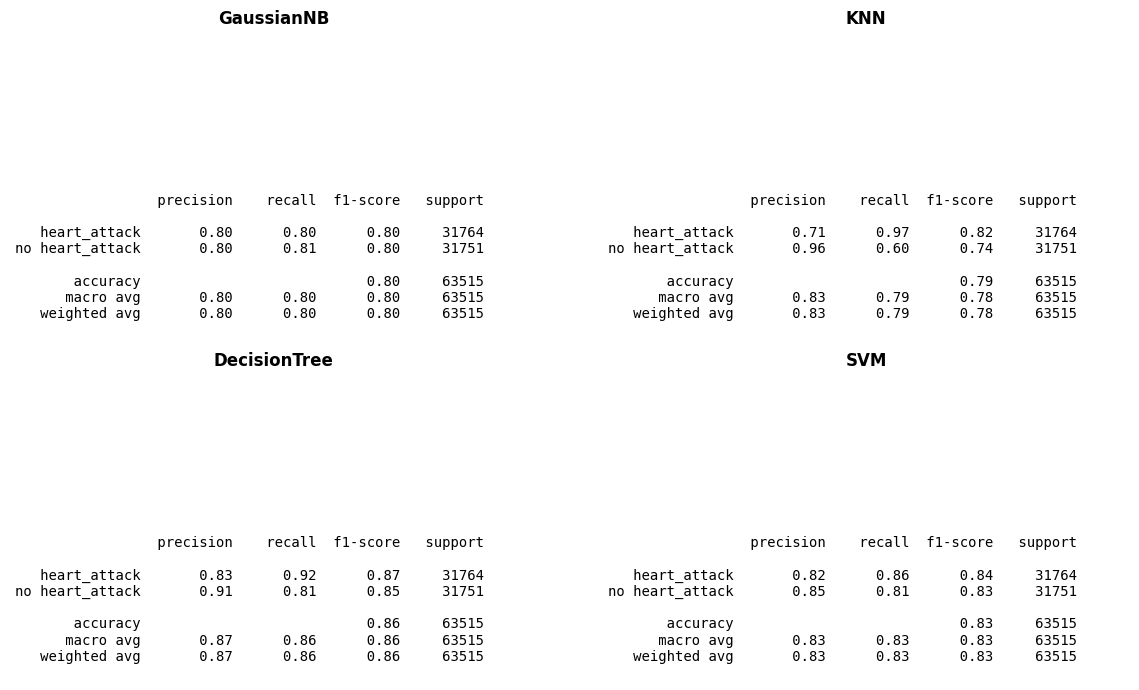

In [ ]:
reportBaggingGNB = classification_report(y_test, modelBaggingGaussianNB.predict(X_test), target_names=['heart_attack', 'no heart_attack'])
reportBaggingKNN = classification_report(y_test, modelBaggingKNN.predict(X_test), target_names=['heart_attack', 'no heart_attack'])
reportBaggingSVM = classification_report(y_test, modelBaggingSVM.predict(X_test), target_names=['heart_attack', 'no heart_attack'])
reportBaggingDT = classification_report(y_test, modelBaggingDT.predict(X_test), target_names=['heart_attack', 'no heart_attack'])


reports = [reportBaggingGNB, reportBaggingKNN, reportBaggingDT, reportBaggingSVM]
titles = ['GaussianNB', 'KNN', 'DecisionTree', 'SVM']
fig, axes = plt.subplots(2, 2, figsize=(12, 7)) 
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80, 
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

## **Random Forest**

In [11]:
# Random Forest Classifier: just for you to see the performance of this algorithm that we already know and compare it
random_forest_classifier = RandomForestClassifier(
    n_estimators = 100
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8652129418247658


In [12]:
# Random Forest Classifier: just for you to see the performance of this algorithm that we already know and compare it
random_forest_classifier = RandomForestClassifier(
    n_estimators = 200
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8650712430134614


In [16]:
@compute_executions_time
def execute_random_forest_with_different_estimators_and_cv(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        random_forest_classifier = RandomForestClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X,
            y = y,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
execute_random_forest_with_different_estimators_and_cv();

Recall: 0.784 [nº estimators (trees): 1]
Recall: 0.666 [nº estimators (trees): 2]
Recall: 0.816 [nº estimators (trees): 5]
Recall: 0.795 [nº estimators (trees): 10]
Recall: 0.804 [nº estimators (trees): 20]
Recall: 0.811 [nº estimators (trees): 50]
Recall: 0.813 [nº estimators (trees): 100]
Recall: 0.814 [nº estimators (trees): 200]

383.44160866737366 seconds


In [17]:
@compute_executions_time
def run_extra_trees_cv_experiment(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        random_forest_classifier = ExtraTreesClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X,
            y = y,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
run_extra_trees_cv_experiment();

Recall: 0.756 [nº estimators (trees): 1]
Recall: 0.630 [nº estimators (trees): 2]
Recall: 0.786 [nº estimators (trees): 5]
Recall: 0.762 [nº estimators (trees): 10]
Recall: 0.776 [nº estimators (trees): 20]
Recall: 0.786 [nº estimators (trees): 50]
Recall: 0.790 [nº estimators (trees): 100]
Recall: 0.790 [nº estimators (trees): 200]

219.99927377700806 seconds


In [18]:
## n_estimators = 100 - see in report
modelRandomForest = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
modelExtraTrees = ExtraTreesClassifier(n_estimators=100).fit(X_train, y_train)

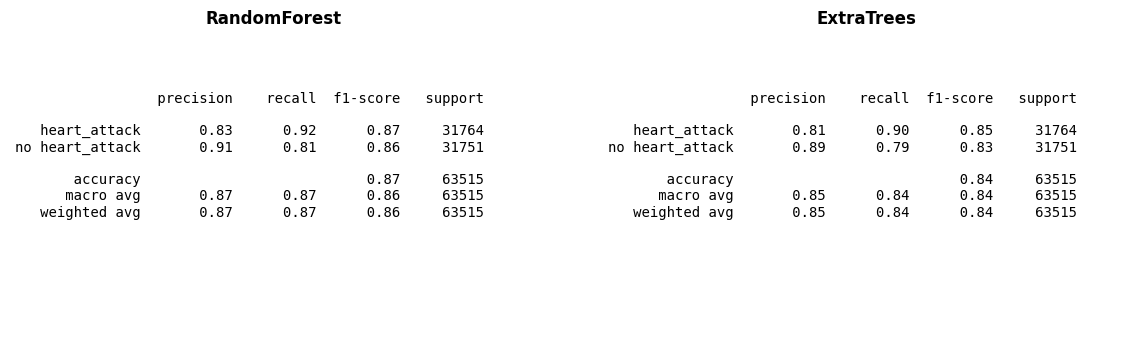

In [19]:
reportRandomForest = classification_report(y_test, modelRandomForest.predict(X_test), target_names=['heart_attack', 'no heart_attack'])
reportExtraTrees = classification_report(y_test, modelExtraTrees.predict(X_test), target_names=['heart_attack', 'no heart_attack'])

reports = [reportRandomForest, reportExtraTrees]
titles = ['RandomForest', 'ExtraTrees']
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5)) 

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80,  
        report,
        fontsize=10,
        family='monospace',
        horizontalalignment='left',
        verticalalignment='top'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [21]:
from statsmodels.stats.contingency_tables import mcnemar

predsA = modelRandomForest.predict(X_test)
predsB = modelExtraTrees.predict(X_test)
both_right = (y_test == predsA) & (y_test == predsB)
only_B_right = (y_test != predsA) & (y_test == predsB)
only_A_right = (y_test == predsA) & (y_test != predsB)
both_wrong = (y_test != predsA) & (y_test != predsB)

contingency_table = [
    [sum(both_right), sum(only_B_right)],
    [sum(only_A_right), sum(both_wrong)]
]
print(f"Contingency table: \n{contingency_table[0]}\n{contingency_table[1]}")

results_mcnemar = mcnemar(contingency_table, exact=False, correction=True)
print(f"Statistics value: {results_mcnemar.statistic}\np-value: {results_mcnemar.pvalue}")

if results_mcnemar.pvalue < 0.05:
  print("Reject Null hypothesis")
else:
  print("Fail to reject Null hypothesis, we can not distinguish both models")

Contingency table: 
[51946, 1688]
[2997, 6884]
Statistics value: 365.17908217716115
p-value: 2.098339405361464e-81
Reject Null hypothesis


In [28]:
from statsmodels.stats.contingency_tables import mcnemar

# Get predictions from both models
pred_rf = modelRandomForest.predict(X_test)
pred_et = modelExtraTrees.predict(X_test)

both_correct = (y_test == pred_rf) & (y_test == pred_et)
only_et_correct = (y_test != pred_rf) & (y_test == pred_et)
only_rf_correct = (y_test == pred_rf) & (y_test != pred_et)
both_wrong = (y_test != pred_rf) & (y_test != pred_et)

table_data = {
    'ExtraTrees Correct': [both_correct.sum(), only_rf_correct.sum()],
    'ExtraTrees Wrong': [only_et_correct.sum(), both_wrong.sum()]
}
index_labels = ['RandomForest Correct', 'RandomForest Wrong']
contingency_df = pd.DataFrame(table_data, index=index_labels)

print("\n Contingency Table:\n")
print(contingency_df)

results_mcnemar = mcnemar(contingency_df.values, exact=False, correction=True)

print("\n McNemar Test Results:")
print(f"Statistics value: {results_mcnemar.statistic}")
print(f"p-value: {results_mcnemar.pvalue}")


if results_mcnemar.pvalue < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis: No significant difference between the models.")



 Contingency Table:

                      ExtraTrees Correct  ExtraTrees Wrong
RandomForest Correct               51946              1688
RandomForest Wrong                  2997              6884

 McNemar Test Results:
Statistics value: 365.17908217716115
p-value: 2.098339405361464e-81
Reject the null hypothesis


## **Ada Boost Classifier**

In [ ]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=10):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X,
            y,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Accuracy: 0.678 [nº estimators: 1]
Accuracy: 0.678 [nº estimators: 2]
Accuracy: 0.794 [nº estimators: 5]
Accuracy: 0.810 [nº estimators: 10]
Accuracy: 0.827 [nº estimators: 20]
Accuracy: 0.860 [nº estimators: 50]
Accuracy: 0.856 [nº estimators: 100]
Accuracy: 0.855 [nº estimators: 200]

327.3711242675781 seconds


In [ ]:
## with cv = 50 to do compare  
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=50):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X,
            y,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Accuracy: 0.678 [nº estimators: 1]
Accuracy: 0.678 [nº estimators: 2]
Accuracy: 0.794 [nº estimators: 5]
Accuracy: 0.810 [nº estimators: 10]
Accuracy: 0.824 [nº estimators: 20]
Accuracy: 0.859 [nº estimators: 50]
Accuracy: 0.857 [nº estimators: 100]
Accuracy: 0.855 [nº estimators: 200]

1947.822978258133 seconds


In [43]:
for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
    modelAdaboostGNB = AdaBoostClassifier(GaussianNB(), n_estimators=n_estimators).fit(X_train, y_train)
    modelAdaboostDT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=n_estimators).fit(X_train, y_train)

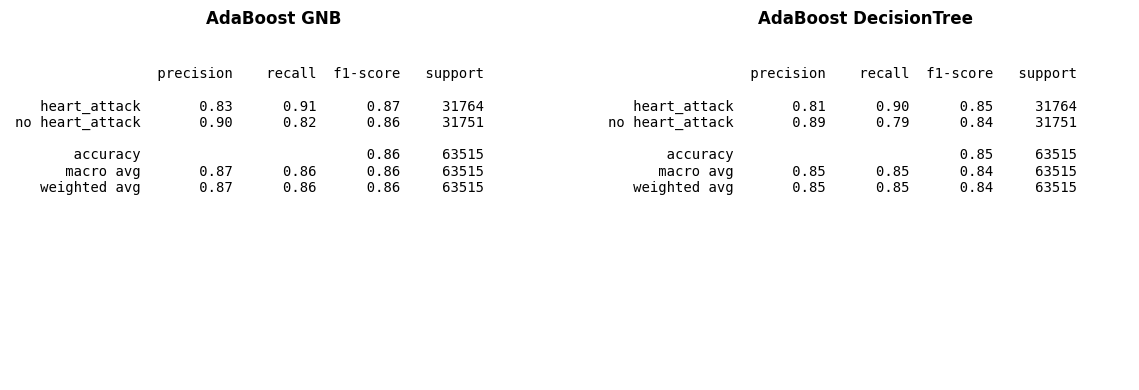

In [47]:
reportAdaboostGNB = classification_report(y_test, modelAdaboostGNB.predict(X_test), target_names=['heart_attack', 'no heart_attack'])
reportAdaboostDT = classification_report(y_test, modelAdaboostDT.predict(X_test), target_names=['heart_attack', 'no heart_attack'])

reports = [reportRandomForest, reportExtraTrees]
titles = ['AdaBoost GNB', 'AdaBoost DecisionTree']
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.90,  # Near top-left corner, top aligned
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [10]:
## ici pour GaussianNB aussi -- voir ca fait quoi après
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(GaussianNB(), n_estimators = n_estimators,  random_state=1), X_train, y_train, cv = 10, scoring = "recall")
    print("Recall GaussianNB: %0.3f [%s]" % (scores.mean(), n_estimators))
print()
## voir si max-depth 5 or 10 c'est mieux 
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators = n_estimators, random_state=1), X_train, y_train, cv = 10, scoring = "recall")
    print("Recall DecisionTreeClassifier: %0.3f [%s]" % (scores.mean(), n_estimators))

Recall: 0.810 [1]
Recall: 0.810 [2]
Recall: 0.848 [5]
Recall: 0.851 [10]
Recall: 0.851 [20]
Recall: 0.851 [50]
Recall: 0.851 [100]
Recall: 0.851 [200]

Recall: 0.766 [1]
Recall: 0.766 [2]
Recall: 0.821 [5]
Recall: 0.832 [10]
Recall: 0.831 [20]
Recall: 0.828 [50]
Recall: 0.828 [100]


KeyboardInterrupt: 